In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('logs.csv')
df.set_index('id', inplace = True)
display(df.shape)
df.head()

(1491154, 15)

,instanceType,freeMem,timeWrite,databaseType,totalMem,timeRead,timeDelete,totalTime,timestamp,serverType,clientTotalTime,requestSize,cpuUsage,frequency,memUsage
id,,,,,,,,,,,,,,,
--4qETfhcD,b1,-1.0,-1.0,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,50.0,-1.0,15.0,-1.0
--Lo0QBj3fC,b1,-1.0,-1.0,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,200.0,-1.0,40.0,-1.0
--P-Z58M2G,b1,-1.0,-1.0,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,1.0,-1.0,15.0,-1.0
--nUeIfVXJ,b1,-1.0,-1.0,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,100.0,-1.0,15.0,-1.0
--od3lhTv,b1,-1.0,-1.0,nosql,-1.0,-1.0,-1.0,-1.0,-1.0,java,-1.0,100.0,-1.0,15.0,-1.0


In [2]:
all_keys = ['clientTotalTime', 'cpuUsage', 'databaseType', 'freeMem', 'frequency', 'id', 'instanceType', 'requestSize', 'serverType', 'timeDelete', 'timeRead', 'timeWrite', 'timestamp', 'totalMem', 'totalTime']

servers = sorted(['java', 'nodejs'])
databases = sorted(['nosql', 'sql'])
instances = sorted(['b1', 'b2', 'b4', 'b8'])

combinations = [(servers[0], databases[0]), (servers[1], databases[0]), (servers[0], databases[1]), (servers[1], databases[1])]

sizes = sorted(list(df['requestSize'].unique()))
frequencies = sorted(list(df['frequency'].unique()))
display(df.dtypes, sizes, frequencies)

instanceType        object
freeMem            float64
timeWrite          float64
databaseType        object
totalMem           float64
timeRead           float64
timeDelete         float64
totalTime          float64
timestamp          float64
serverType          object
clientTotalTime    float64
requestSize        float64
cpuUsage           float64
frequency          float64
memUsage           float64
dtype: object

[1.0, 5.0, 20.0, 50.0, 100.0, 200.0, 500.0]

[1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 40.0, 60.0]

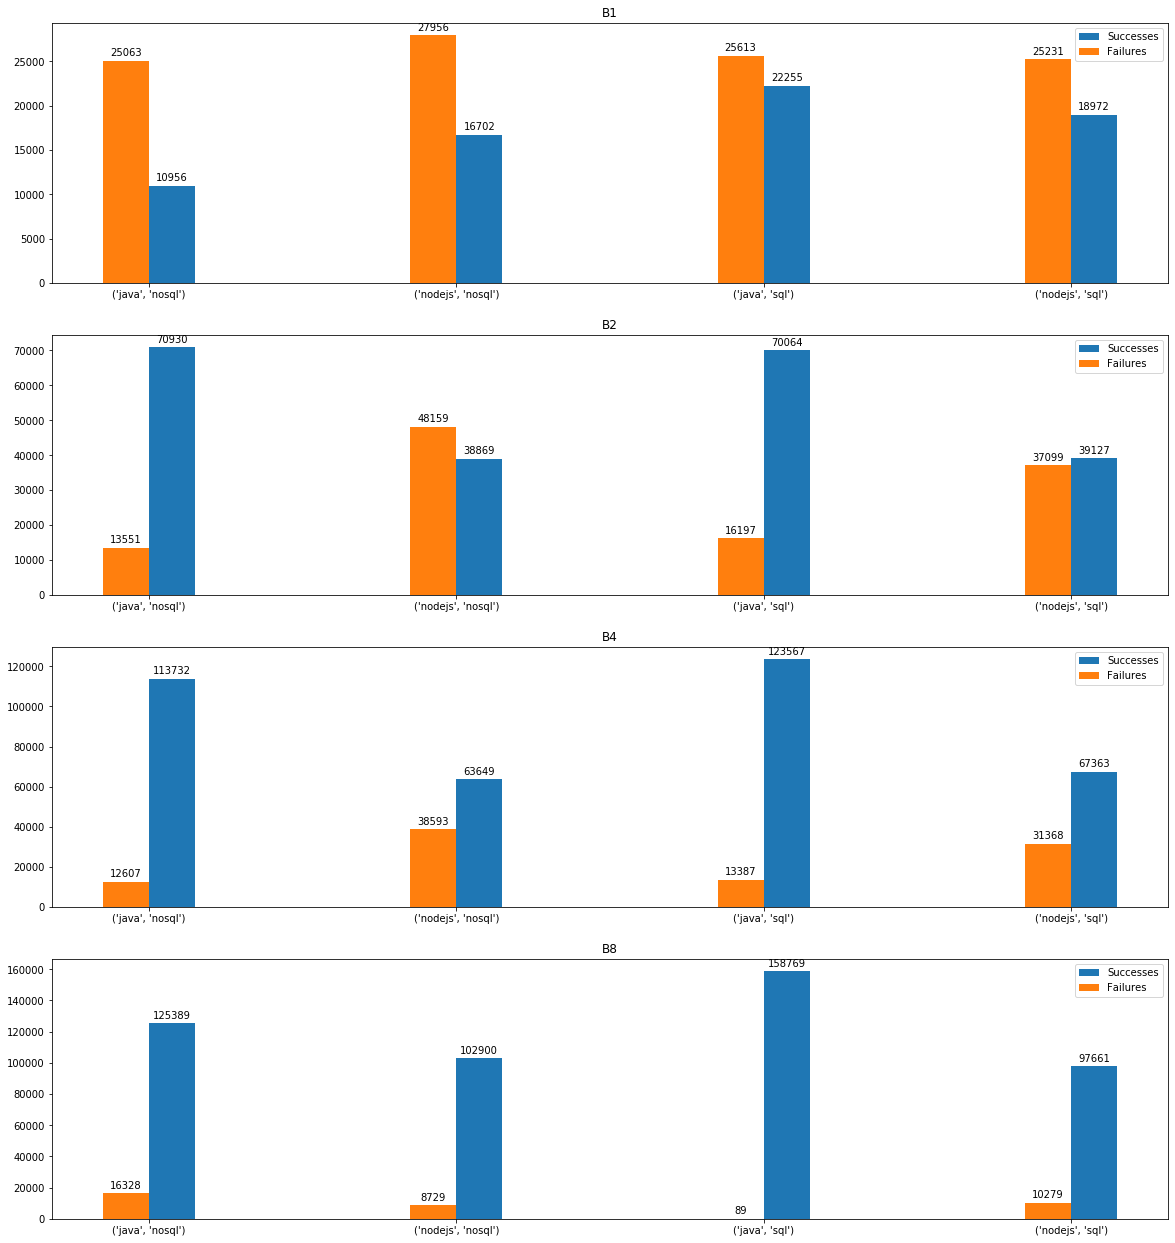

In [3]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


fig, axes = plt.subplots(4)

for i, instance in enumerate(instances):
    ax = axes[i]
    
    success_arr = []
    error_arr = []
    ns = []
    
    for combination in combinations:
        server, database = combination

        partial = df.loc[(df['instanceType'] == instance) & (df['serverType'] == server) & (df['databaseType'] == database)]
        
        error = partial[(partial.clientTotalTime == -1) | (partial.requestSize == -1) |
                            (partial.frequency == -1) | (partial.timeWrite == -1) | (partial.timeRead == -1) |
                            (partial.timeDelete == -1) | (partial.totalTime == -1) | (partial.timestamp == -1) |
                           (partial.memUsage == -1)].shape[0]
        
        total = partial.shape[0]
        success = total - error
        success_arr.append(success)
        error_arr.append(error)
        ns.append(total)

    ind = np.arange(len(combinations))  
    width = 0.15
    rects1 = ax.bar(ind + 0.5 * width, success_arr, width, label='Successes')
    rects2 = ax.bar(ind - 0.5 * width, error_arr, width, label='Failures')

    ax.set_ylim(0)
    ax.set_title(instance.upper())
    ax.set_xticks(ind)
    ax.set_xticklabels(combinations)
    ax.legend()
    ax.autoscale_view()
    autolabel(rects1)
    autolabel(rects2)


fig.set_size_inches(20, 22)
plt.savefig('graphs/ErrorRates.png', bbox_inches='tight')
plt.show()